#Import libraries

In [1]:
# Standard libraries
import math
import time
import random
from typing import List, Tuple, Optional, Union

# Numerical and GPU computation libraries
import numpy as np
from numba import cuda, jit, prange, float32

# Image processing libraries
import cv2
from PIL import Image

# Plotting libraries
import matplotlib.pyplot as plt

#Kernel definitions

##Computing kernel

In [ ]:
class Compute:
    @staticmethod
    @cuda.jit
    def _calculate_distances_gpu(X, centroids, distances):

        # Shared memory for centroids and data points
        TPB = 32
        shared_X = cuda.shared.array((TPB, TPB), dtype=np.float32)
        shared_centroids = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i, j = cuda.grid(2)  # Thread indices

        # Load X and centroids into shared memory
        if i < X.shape[0] and j < centroids.shape[0]:
            for d in range(X.shape[1]):
                if cuda.threadIdx.x < 32 and cuda.threadIdx.y < 32:
                    shared_X[cuda.threadIdx.x, d] = X[i, d]
                    shared_centroids[cuda.threadIdx.y, d] = centroids[j, d]
            cuda.syncthreads()  # Synchronize to ensure shared memory is fully loaded

            # Compute the distance using shared memory
            dist = 0.0
            for d in range(X.shape[1]):
                diff = shared_X[cuda.threadIdx.x, d] - shared_centroids[cuda.threadIdx.y, d]
                dist += diff * diff
            distances[i, j] = math.sqrt(dist)  # Store the computed distance

    @staticmethod
    @cuda.jit
    def _calculate_centroids_gpu(X, labels, centroids, n_points_per_cluster):
        # Shared memory for intermediate centroid sums
        TPB = 32
        shared_centroids = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i = cuda.grid(1)  # Thread index

        if i < X.shape[0]:  # Ensure we are within bounds
            cluster_id = labels[i]

            # Accumulate sums in shared memory
            for d in range(X.shape[1]):
                cuda.atomic.add(shared_centroids, (cluster_id, d), X[i, d])

            # Synchronize threads to make sure all sums are accumulated
            cuda.syncthreads()

            # Copy the shared memory values to the global centroids and count arrays
            if cuda.threadIdx.x == 0:
                for d in range(X.shape[1]):
                    cuda.atomic.add(centroids, (cluster_id, d), shared_centroids[cluster_id, d])
                cuda.atomic.add(n_points_per_cluster, cluster_id, 1)




    # New methods for FCM
    @staticmethod
    @cuda.jit
    def _update_membership_matrix_gpu(distances, membership_matrix, m):

        TPB = 32
        shared_distances = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i, j = cuda.grid(2)
        if i < distances.shape[0] and j < distances.shape[1]:
            shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] = distances[i, j]
            cuda.syncthreads()

            if shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] < 1e-10:
                shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] = 1e-10

            power = 2.0 / (m - 1.0)
            sum_inv = 0.0

            for k in range(distances.shape[1]):
                if shared_distances[cuda.threadIdx.x, k] < 1e-10:
                    shared_distances[cuda.threadIdx.x, k] = 1e-10
                sum_inv += (shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] / shared_distances[cuda.threadIdx.x, k]) ** power

            membership_matrix[i, j] = 1.0 / sum_inv

    @staticmethod
    @cuda.jit
    def _update_centroids_gpu_fcm(X, membership_matrix, centroids, m):

        TPB = 32
        shared_membership = cuda.shared.array((TPB, TPB), dtype=np.float32)
        shared_X = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i, j = cuda.grid(2)
        if i < centroids.shape[0] and j < centroids.shape[1]:
            numerator = 0.0
            denominator = 0.0

            for k in range(X.shape[0]):
                shared_membership[cuda.threadIdx.x, cuda.threadIdx.y] = membership_matrix[k, i]
                shared_X[cuda.threadIdx.x, cuda.threadIdx.y] = X[k, j]
                cuda.syncthreads()

                weight = shared_membership[cuda.threadIdx.x, cuda.threadIdx.y] ** m
                numerator += weight * shared_X[cuda.threadIdx.x, cuda.threadIdx.y]
                denominator += weight

            if denominator > 0:
                centroids[i, j] = numerator / denominator

##Base Clustering

In [2]:
class BaseClustering:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100, random_state: int = None):
        """
        Initialize Base Clustering

        Parameters:
        - n_clusters: Number of clusters
        - max_iter: Maximum iterations
        - random_state: Seed for reproducibility
        """

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None

    def _initialize_centroids(self, X: np.ndarray) -> None:
        """Initialize centroids randomly from data points"""

        if self.random_state is not None:
            np.random.seed(self.random_state)

        random_idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idx].astype(np.float32)

    def _setup_gpu_arrays(self, X: np.ndarray):
        """Setup common GPU arrays used in clustering"""

        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_distances = cuda.device_array((X.shape[0], self.n_clusters), dtype=np.float32)

        return d_X, d_centroids, d_distances

    def _calculate_grid_dimensions(self, X: np.ndarray):
        """Calculate grid dimensions for GPU computation"""

        threads_per_block = (32, 32)
        blocks_per_grid_x = (X.shape[0] + (threads_per_block[0] - 1)) // threads_per_block[0]
        blocks_per_grid_y = (self.n_clusters + (threads_per_block[1] - 1)) // threads_per_block[1]
        blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

        return threads_per_block, blocks_per_grid

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Base predict method to be implemented by subclasses"""
        raise NotImplementedError("Subclasses must implement predict method")

    def fit(self, X: np.ndarray):
        """Base fit method to be implemented by subclasses"""
        raise NotImplementedError("Subclasses must implement fit method")


##KMeans kernel

In [3]:
class KMeans(BaseClustering):
    def __init__(self, n_clusters: int = 3, max_iter: int = 100, random_state: int = None):
        super().__init__(n_clusters, max_iter, random_state)
        self.labels = None

    def fit(self, X: np.ndarray) -> 'KMeans':
        print("Debugging KMeans (KM) - fit")
        X = X.astype(np.float32)
        self._initialize_centroids(X)

        # Setup GPU arrays
        d_X, d_centroids, d_distances = self._setup_gpu_arrays(X)
        d_labels = cuda.device_array(X.shape[0], dtype=np.int32)
        n_points_per_cluster = cuda.device_array(self.n_clusters, dtype=np.int32)

        # Calculate grid dimensions
        threads_per_block, blocks_per_grid = self._calculate_grid_dimensions(X)

        for _ in range(self.max_iter):
            # Calculate distances
            Compute._calculate_distances_gpu[blocks_per_grid, threads_per_block](
                d_X, d_centroids, d_distances
            )
            cuda.synchronize()

            # Update labels
            distances = d_distances.copy_to_host()
            labels = np.argmin(distances, axis=1)

            # Update centroids
            Compute._calculate_centroids_gpu[blocks_per_grid, threads_per_block](
                d_X, d_labels, d_centroids, n_points_per_cluster
            )
            cuda.synchronize()

            # Check convergence
            counts = n_points_per_cluster.copy_to_host()
            counts[counts == 0] = 1
            new_centroids = d_centroids.copy_to_host() / counts[:, None]
            new_centroids = np.nan_to_num(new_centroids, nan=0.0, posinf=255, neginf=0)
            new_centroids = new_centroids.astype('uint8')

            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        print("Debugging KMeans (KM) - predict")

        # Setup GPU arrays
        d_X, d_centroids, d_distances = self._setup_gpu_arrays(X)

        # Calculate grid dimensions
        threads_per_block, blocks_per_grid = self._calculate_grid_dimensions(X)

        # Calculate distances
        Compute._calculate_distances_gpu[blocks_per_grid, threads_per_block](
            d_X, d_centroids, d_distances
        )
        cuda.synchronize()

        # Get labels
        distances = d_distances.copy_to_host()
        return np.argmin(distances, axis=1)


##Fuzzy C-Means kernel

In [4]:
class FuzzyCMeans(BaseClustering):
    def __init__(self, n_clusters: int = 3, max_iter: int = 100,
                 m: float = 2.0, epsilon: float = 1e-4, random_state: int = None):
        super().__init__(n_clusters, max_iter, random_state)
        self.m = m
        self.epsilon = epsilon
        self.membership_matrix = None

    def fit(self, X: np.ndarray) -> 'FuzzyCMeans':
        print("Debugging FuzzyCMeans (FCM) - fit")
        self._initialize_centroids(X)

        # Initialize membership matrix
        n_samples = X.shape[0]
        self.membership_matrix = np.random.dirichlet(np.ones(self.n_clusters),
                                                   size=n_samples).astype(np.float32)

        # Setup GPU arrays
        d_X, d_centroids, d_distances = self._setup_gpu_arrays(X)
        d_membership = cuda.device_array_like(self.membership_matrix)

        # Calculate grid dimensions
        threads_per_block, blocks_per_grid = self._calculate_grid_dimensions(X)

        for _ in range(self.max_iter):
            prev_centroids = self.centroids.copy()

            # Calculate distances and update membership
            Compute._calculate_distances_gpu[blocks_per_grid, threads_per_block](
                d_X, d_centroids, d_distances
            )
            cuda.synchronize()

            Compute._update_membership_matrix_gpu[blocks_per_grid, threads_per_block](
                d_distances, d_membership, self.m
            )
            cuda.synchronize()

            # Update centroids
            self.membership_matrix = d_membership.copy_to_host()
            d_new_centroids = cuda.device_array_like(self.centroids)

            Compute._update_centroids_gpu_fcm[blocks_per_grid, threads_per_block](
                d_X, d_membership, d_new_centroids, self.m
            )
            cuda.synchronize()

            self.centroids = d_new_centroids.copy_to_host()

            if np.allclose(prev_centroids, self.centroids, atol=self.epsilon):
                break

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.membership_matrix, axis=1)

#Behaviors

In [5]:
class ImageClustering:
    def __init__(self, clustering_method, n_clusters=10):
        """
        Initialize Image Clustering

        Parameters:
        - clustering_method: KMeans or FuzzyCMeans class
        - n_clusters: Number of colors to reduce to
        """
        self.clustering_method = clustering_method
        self.n_clusters = n_clusters
        self.clusterer = None

    def load_image(self, image_path):
        """
        Load and preprocess image

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image array
        - Flattened image data
        """
        try:
            # Open the image
            image = Image.open(image_path)

            # Convert to numpy array
            image_array = np.array(image)

            # Check if the image has 3 channels (RGB)
            if image_array.ndim != 3 or image_array.shape[2] != 3:
                raise ValueError("Image must have 3 color channels (RGB).")

            # Reshape image to 2D array of pixels
            pixels = image_array.reshape((-1, 3)).astype(np.float32)  # Use float32 for CUDA

            return image_array, pixels

        except Exception as e:
            raise IOError(f"Error loading image: {e}")

    def quantize_image(self, image_path):
        """
        Perform color quantization

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image
        - Quantized image
        - Centroids (for cluster colors)
        - Labels (cluster assignments for each pixel)
        """

        print("Debugging ImageCluster (IC) - quantize_image")

        # Load image
        original_image, pixels = self.load_image(image_path)

        try:
            # Start timing
            start_time = time.perf_counter()  # better

            print("IC.q_i.1")

            # Perform clustering
            self.clusterer = self.clustering_method(n_clusters=self.n_clusters)

            print("IC.q_i.2")

            self.clusterer.fit(pixels)

            print("IC.q_i.3")

            # Get cluster centroids and labels for each pixel
            centroids = self.clusterer.centroids.astype('uint8')  # Ensure centroids are uint8 for color representation

            print("IC.q_i.4")

            labels = self.clusterer.predict(pixels)

            print("IC.q_i.5")

            # Reconstruct image using cluster centroids
            quantized_pixels = centroids[labels].astype('uint8')

            print("IC.q_i.6")

            # Reshape back to original image shape
            quantized_image = quantized_pixels.reshape(original_image.shape)

            # End timing
            end_time = time.perf_counter()  # better

            print(f"Clustering Time: {end_time - start_time:.4f} seconds")

            return original_image, quantized_image, centroids, labels, pixels

        except Exception as e:
            raise RuntimeError(f"Error during color quantization: {e}")

    def visualize_results(self, original_image, quantized_image):
        """
        Visualize original and quantized images

        Parameters:
        - original_image: Original image array
        - quantized_image: Quantized image array
        """
        # Create figure with two subplots
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        # Quantized Image
        plt.subplot(1, 2, 2)
        plt.title(f'Quantized Image ({self.n_clusters} Colors)')
        plt.imshow(quantized_image)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, pixels, labels, centroids):
        """
        Visualize clusters in 2D space

        Parameters:
        - pixels: Original pixel data (flattened image)
        - labels: Cluster labels for each pixel
        - centroids: Centroid colors for each cluster
        - method: Dimensionality reduction method ('pca' or 'tsne')
        """

        # Reduce dimensions
        plt.figure(figsize=(8, 6))

        # Plot each cluster with its centroid color
        for i, color in enumerate(centroids):
            cluster_pixels = pixels[labels == i]

            # Using RGB color components for 2D plotting
            plt.scatter(cluster_pixels[:, 0], cluster_pixels[:, 1],
                        color=np.clip(color / 255, 0, 1),          # Normalize to [0,1] for matplotlib
                        label=f'Cluster {i}', s=10, alpha=0.6)

        # Mark the centroids in black
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

        plt.title("Cluster Visualization with Exact Colors")
        plt.xlabel("Red channel")
        plt.ylabel("Green channel")
        plt.legend()
        plt.show()

    def save_quantized_image(self, quantized_image, output_path):
        """
        Save quantized image

        Parameters:
        - quantized_image: Quantized image array
        - output_path: Path to save the image
        """
        Image.fromarray(quantized_image).save(output_path)

#TEST

Debugging!
Debugging ImageCluster (IC) - quantize_image
IC.q_i.1
IC.q_i.2
Debugging FuzzyCMeans (FCM) - fit
IC.q_i.3
IC.q_i.4
IC.q_i.5
IC.q_i.6
Clustering Time: 1.4712 seconds


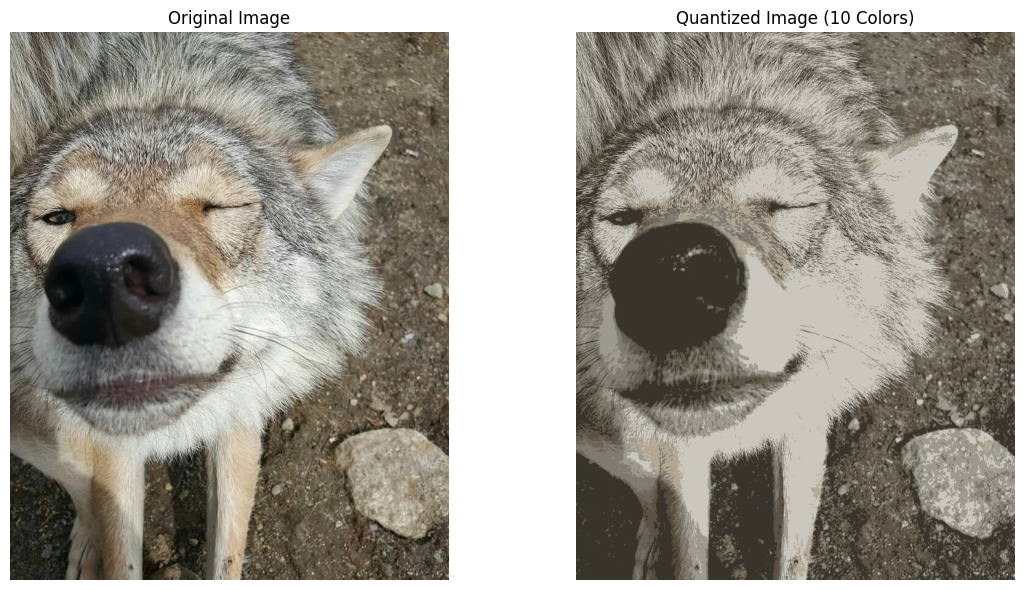

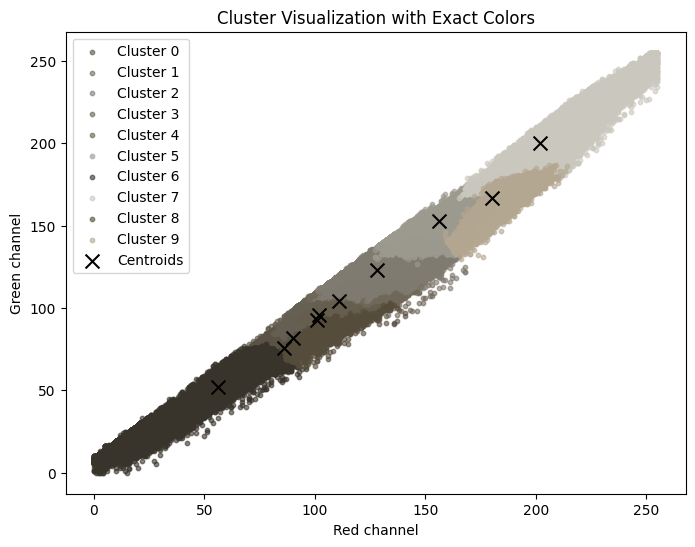

Debugging ImageCluster (IC) - quantize_image
IC.q_i.1
IC.q_i.2
Debugging FuzzyCMeans (FCM) - fit
IC.q_i.3
IC.q_i.4
IC.q_i.5
IC.q_i.6
Clustering Time: 0.4544 seconds


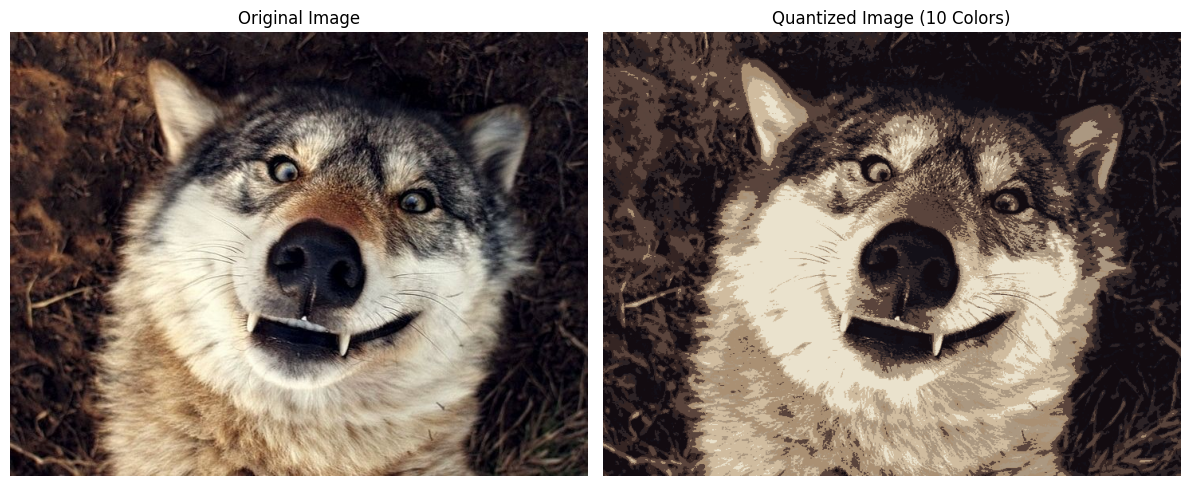

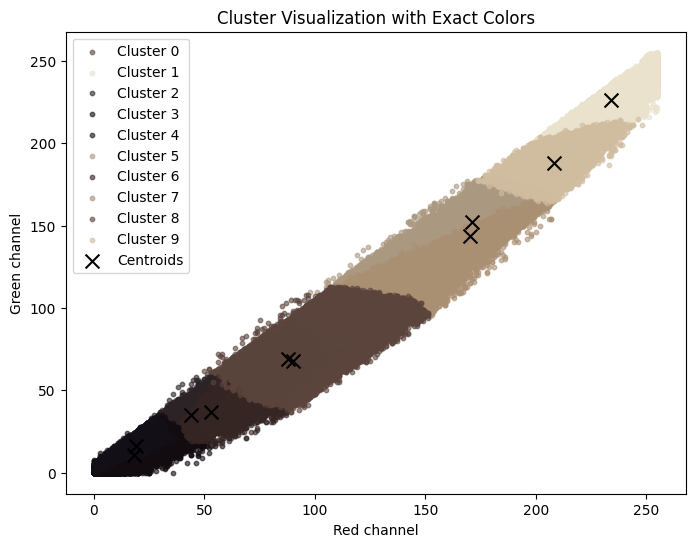

In [13]:
def main():
    # Image path
    image_path_1 = '/content/wolf1.jpg'
    image_path_2 = '/content/wolf2.jpg'

    # Create image clustering instance
    image_clusterer = ImageClustering(
        # clustering_method=KMeans,         # Choose KMeans or FuzzyCMeans
        clustering_method=FuzzyCMeans,    # Choose KMeans or FuzzyCMeans
        n_clusters=10                       # Number of colors
    )

    try:
        print("Debugging!")

        image_paths = [image_path_1, image_path_2]

        # Perform color quantization
        for i in range(len(image_paths)):
            original, quantized, centroids, labels, pixels = image_clusterer.quantize_image(image_paths[i])

            # Visualize results and cluster colors in 2D space
            image_clusterer.visualize_results(original, quantized)
            image_clusterer.visualize_clusters(pixels, labels, centroids)

            # Optionally save quantized image
            image_clusterer.save_quantized_image(
                quantized,
                f'/content/quantized_image_{i+1}.jpg'
            )


    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == "__main__":
    main()

In [12]:
class Compute:
    @staticmethod
    @cuda.jit
    def _calculate_distances_gpu(X, centroids, distances):
        """
        Compute the distances between data points and centroids on the GPU.
        Optimized to reduce thread divergence and improve shared memory usage.
        """

        # Shared memory for centroids and data points
        TPB = 32
        shared_X = cuda.shared.array((TPB, TPB), dtype=np.float32)
        shared_centroids = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i, j = cuda.grid(2)  # Thread indices

        # Load X and centroids into shared memory
        if i < X.shape[0] and j < centroids.shape[0]:
            # Use coalesced memory access
            for d in range(0, X.shape[1], TPB):
                shared_X[cuda.threadIdx.x, d + cuda.threadIdx.y] = X[i, d + cuda.threadIdx.y]
                shared_centroids[cuda.threadIdx.y, d + cuda.threadIdx.x] = centroids[j, d + cuda.threadIdx.x]

            cuda.syncthreads()  # Synchronize to ensure shared memory is fully loaded

            # Compute the distance using shared memory
            dist = 0.0
            for d in range(X.shape[1]):
                diff = shared_X[cuda.threadIdx.x, d] - shared_centroids[cuda.threadIdx.y, d]
                dist += diff * diff
            distances[i, j] = math.sqrt(dist)  # Store the computed distance

    @staticmethod
    @cuda.jit
    def _calculate_centroids_gpu(X, labels, centroids, n_points_per_cluster):
        # Shared memory for intermediate centroid sums
        TPB = 32
        shared_centroids = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i = cuda.grid(1)  # Thread index

        if i < X.shape[0]:  # Ensure we are within bounds
            cluster_id = labels[i]

            # Accumulate sums in shared memory
            for d in range(X.shape[1]):
                cuda.atomic.add(shared_centroids, (cluster_id, d), X[i, d])

            # Synchronize threads to make sure all sums are accumulated
            cuda.syncthreads()

            # Copy the shared memory values to the global centroids and count arrays
            if cuda.threadIdx.x == 0:
                for d in range(X.shape[1]):
                    cuda.atomic.add(centroids, (cluster_id, d), shared_centroids[cluster_id, d])
                cuda.atomic.add(n_points_per_cluster, cluster_id, 1)




    # New methods for FCM
    @staticmethod
    @cuda.jit
    def _update_membership_matrix_gpu(distances, membership_matrix, m):
        """
        Update the membership matrix for Fuzzy C-Means (FCM) on the GPU.
        Optimized to reduce thread divergence and avoid excessive synchronization.
        """

        TPB = 32

        i, j = cuda.grid(2)
        if i < distances.shape[0] and j < distances.shape[1]:
            # Load distances into shared memory
            shared_distances = cuda.shared.array((TPB, TPB), dtype=np.float32)
            shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] = distances[i, j]
            cuda.syncthreads()

            # Avoid division by zero
            if shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] < 1e-10:
                shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] = 1e-10

            power = 2.0 / (m - 1.0)
            sum_inv = 0.0

            for k in range(distances.shape[1]):
                if shared_distances[cuda.threadIdx.x, k] < 1e-10:
                    shared_distances[cuda.threadIdx.x, k] = 1e-10
                sum_inv += (shared_distances[cuda.threadIdx.x, cuda.threadIdx.y] / shared_distances[cuda.threadIdx.x, k]) ** power

            membership_matrix[i, j] = 1.0 / sum_inv

    @staticmethod
    @cuda.jit
    def _update_centroids_gpu_fcm(X, membership_matrix, centroids, m):
        """
        Update the centroids for Fuzzy C-Means (FCM) on the GPU.
        Optimized to reduce thread divergence and avoid excessive synchronization.
        """

        TPB = 32
        shared_membership = cuda.shared.array((TPB, TPB), dtype=np.float32)
        shared_X = cuda.shared.array((TPB, TPB), dtype=np.float32)

        i, j = cuda.grid(2)
        if i < centroids.shape[0] and j < centroids.shape[1]:
            numerator = 0.0
            denominator = 0.0

            for k in range(0, X.shape[0], TPB):
                shared_membership[cuda.threadIdx.x, cuda.threadIdx.y] = membership_matrix[k + cuda.threadIdx.x, i]

                shared_X[cuda.threadIdx.x, cuda.threadIdx.y] = X[k + cuda.threadIdx.x, j]

                cuda.syncthreads()

                weight = shared_membership[cuda.threadIdx.x, cuda.threadIdx.y] ** m
                numerator += weight * shared_X[cuda.threadIdx.x, cuda.threadIdx.y]
                denominator += weight

            if denominator > 0:
                centroids[i, j] = numerator / denominator